## Assignment 2: 

First task for Assignment Part 2 is to code up the teacher model, and use it to generate some data sets of toy sentences for a few different values of the embedding dimensionality 𝐷(e.g., 𝐷=100 and 𝐷 = 1000).
All the hyperparameter settings are initially to be kept the same as in the Cui et al. paper (the same values were also mentioned in class). But try to write your code in a way where these settings can be easily changed later on, to enable future experiments with the same code.
Data generation part at least should be pretty straightforward. After that, the next step should be to get familiar with how to train simple transformer models in PyTorch, so that you can use that to train the student model on the generated data sets. We will discuss the student model further next week.

- Use bash for running code?

### References:
[Cui et al](https://web.iitd.ac.in/~sumeet/Cui_24.pdf)

# TODO:
-   Do CV for lambda
-   implement plots for both (train,gen)
-   rest is just plots
-   fig 2A,2B,3B code all entangled ()
-   fig 3C,2C code entangled
-   fig 3A completely independent
-   the business of taking means,multiple iterations etc...

# Checks:
-   Teacher model is exactly same as theirs
-   Student model :
        - D vs D_k norm confusion
        - pos and sem are same for D_k norm
        - shapes are weird -> causing problems in m,theta

# Do final runs:
### Run 1:
- Use sqrt(D)
- Use CV lamba 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import *
import pandas as pd
from pathlib import Path
import warnings
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors
warnings.simplefilter("ignore", UserWarning)

# different colors for attention values
c_semantic='deeppink'
c_positional='royalblue'
c_att = 'rebeccapurple'

# different colors for the lienar student
c_lin = 'orange'

# colors for the phase transition borders
c_attlin = 'crimson' 
c_spinodal = 'forestgreen'

# color for changing specific parameters
c_no_col = 'black'


cmap_uninf = LinearSegmentedColormap.from_list('INF-UNINF',
                                                   [mcolors.to_rgba(c_semantic)[:3], (1, 1, 1), mcolors.to_rgba(c_positional)[:3]], N=100)
cmap_attlin = LinearSegmentedColormap.from_list('INF-UNINF',
                                                   [mcolors.to_rgba(c_lin)[:3], (1, 1, 1), mcolors.to_rgba(c_att)[:3]], N=100)
cmap_pos = LinearSegmentedColormap.from_list('INF-UNINF',
                                                   [mcolors.to_rgba('#8DE0A8')[:3],
                                                    mcolors.to_rgba('#93FFE0')[:3],
                                                    mcolors.to_rgba('#85EFFF')[:3],
                                                    mcolors.to_rgba('#6BBFFF')[:3],
                                                    mcolors.to_rgba(c_positional)[:3]], N=100)
cmap_att = LinearSegmentedColormap.from_list('INF-UNINF',
                                                   [mcolors.to_rgba('#FFE0B6')[:3],
                                                    mcolors.to_rgba('#FFB48C')[:3],
                                                    mcolors.to_rgba('#FF8166')[:3],
                                                    mcolors.to_rgba('#FF3E3B')[:3],
                                                    mcolors.to_rgba(c_semantic)[:3]], N=100)

In [2]:
import torch
import numpy as np

# they divided by sqrt(D) should you do that ?
def generate_teacher_dataset(N, D=100, L=2, DK=1, omega=0.3, seed=None):
    """
    Generate a teacher dataset of size N
    """
    if seed is not None:
        torch.manual_seed(seed)
    
    # Generate shared query weight matrix
    W_Q = torch.randn(D)
    sigma = 0.5 # sample X from multivariate gaussian, var->0.25
    X_all = sigma * torch.randn((N, L, D)) 

    softmax=torch.nn.Softmax(dim=-1)

    xQ = torch.einsum("imk,k->im", X_all, W_Q)
    att_score = softmax(torch.einsum("im,in->imn", xQ, xQ))

    pos_matrix = torch.Tensor(np.array([[.6,.4],[.4,.6]]))

    T_all = (1-omega) * torch.einsum("imn,inj->imj", att_score, X_all) + omega * torch.einsum("nld,fl->nfd", X_all, pos_matrix)

    return X_all, T_all, W_Q


# parameters
L = 2                # Number of words per sentence
D = 1000           # Dimensionality
N = int(2.2 * D)     # Dataset size
DK = 1               # Dimensionality of key/query vectors
omega = 0.3          # weight for positional component
seed = 42            
sigma = 0.5
# Generate teacher dataset
X, T, W_Q_teacher = generate_teacher_dataset(
    N=N, D=D, L=L, DK=DK, omega=omega, seed=seed
)


print(f"X_teacher shape: {X.shape}") #(N,L,D)
print(f"T_teacher shape: {T.shape}") #(N,L,D)
print(f"W_Q_teacher shape: {W_Q_teacher.shape}") #(D_k,D)
W =  W_Q_teacher.clone()


X_teacher shape: torch.Size([2200, 2, 1000])
T_teacher shape: torch.Size([2200, 2, 1000])
W_Q_teacher shape: torch.Size([1000])


In [3]:
''' Student Model '''
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

# here they divide positional encoding by sqrt(D) why investigate (same in forward and W_Q)
# check the positional embeddings once
class StudentAttentionModel(nn.Module):
    def __init__(self, D=100, DK=1, L=2, init_type='random', WQ_teacher=None):
        super().__init__()
        self.D = D
        self.DK = DK
        self.L = L

        # initialization of W
        if init_type == 'semantic':
            self.W_Q = torch.nn.Parameter(WQ_teacher.reshape(-1, 1))
        elif init_type == 'positional':

            self.W_Q = torch.nn.Parameter(torch.ones(D).reshape(-1, 1))
        else:
            self.W_Q = torch.nn.Parameter(torch.randn(D, DK))
    def forward(self, X):
        """
        X: (batch_size, L, D)
        Returns:
            Y: (batch_size, L, D)
        """
        # Add positional encodings
        B,L,D = X.shape
        # Positional encoding: r1 = -r2 = 1_D
        r1= torch.ones(D)
        R = torch.vstack((r1, -r1))
        Rs =  np.repeat(R[np.newaxis, :, :], B, axis=0)

        X_pos = X + Rs  # (B, L, D)
        
        xQ = torch.einsum("imk,kl->iml", X_pos, self.W_Q) # why have they divided by D
        A = torch.nn.Softmax(dim=-1)(torch.einsum("iml,inl->imn", xQ, xQ))
        Y = torch.einsum("imn,inj->imj", A, X_pos)

        return Y


def loss_SSE(Y, T):
    return torch.sum((Y-T)**2)/2/T.shape[-1]
# change num epochs

def train_student(X_train, T_train, X_test, T_test, lam=1e-2, lr=0.15, epochs=5000,init_type='semantic',W_Q_teacher = None,DK=1):
    '''
    Trains a student attention model with specified initialization. 
    lam : L2 regularisation parameter
    '''
    N, L, D = X_train.shape
    
    # Create a DataLoader for mini-batching
    train_dataset = TensorDataset(X_train, T_train)
    train_loader = DataLoader(train_dataset, batch_size=N, shuffle=True)


    model = StudentAttentionModel(
        D=D, DK=DK, L=L,
        init_type=init_type,
        WQ_teacher=W_Q_teacher
    )

    gen_error_list = []
    train_error_list = []
    m_list,theta_list = [],[]
    r1 = torch.ones(D)

    optimizer = torch.optim.SGD([{'params': [model.W_Q],"weight_decay":lam }], lr=0.15)

    #print(model.W_Q[:2],init_type)
    er_list = []
    for epoch in range(epochs):
        epoch_loss = 0
        num_batches = 0
        for X_batch, T_batch in train_loader:
            optimizer.zero_grad()
            Y_pred = model(X_batch)
            loss = loss_SSE(Y_pred, T_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            num_batches += 1
        W_Q_flat = model.W_Q.flatten()
        W_Q_teacher_flat = W_Q_teacher.flatten()
        if(epoch > epochs-20):
            gen_error_list.append(loss_SSE(model(X_test),T_test).item()/T_test.shape[0])
            train_error = (loss.item()/T_train.shape[0]) +lam/2*float(torch.sum(W_Q_flat**2))
            train_error_list.append(train_error)
            m = np.abs(float(r1@ W_Q_flat /D))
            theta = np.abs(float(W_Q_teacher_flat @ W_Q_flat/D))
            m_list.append(m)
            theta_list.append(theta)
        er_list.append(epoch_loss/num_batches)
    plt.figure()
    plt.plot(er_list)
    plt.show()
 
    return model, np.mean(gen_error_list[-5:]),np.mean(train_error_list[-5:]), np.mean(m_list[-5:]), np.mean(theta_list[-5:])

In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy


def train_student_L2_CV(X_train, T_train, X_val, T_val, lam_list, lr=0.15, epochs=5000, init_type='semantic', W_Q_teacher=None, DK=1):
    '''
    Performs cross-validation over a list of lambda values and returns the best lambda and associated metrics.
    '''
    results = []

    for lam in lam_list:
        model, gen_error, train_error, m, theta = train_student(
            X_train, T_train,
            X_val, T_val,
            lam=lam,
            lr=lr,
            epochs=epochs,
            init_type=init_type,
            W_Q_teacher=W_Q_teacher,
            DK=DK
        )
        results.append({
            'lam': lam,
            'gen_error': gen_error,
            'train_error': train_error,
            'm': m,
            'theta': theta,
            'model': model
        })

    # Find best lambda (lowest generalization error)
    best_result = min(results, key=lambda x: x['gen_error'])
    
    return best_result['model'],best_result['gen_error'],best_result['train_error'],best_result['m'],best_result['theta']


def run_fig_2A(X, T, lam=[1e-2], lr=0.15, epochs=5000, DK=1,WQ_teacher = None,alphas=None):
    """
    Runs the generalization experiment comparing semantic vs positional initialization
    across sample complexity α = N_train / D.
    
    Args:
        X, T: torch.Tensor of shape (N, L, D)
        lam: regularization strength
        lr: learning rate
        epochs: number of training epochs
        DK: key/query dimension

    Returns:
        results: list of dicts with alpha, semantic_loss, positional_loss, and delta
    """

    D = X.shape[2]
    L = X.shape[1]
    results = []

    # Fixed test set
    N_test = int(0.2 * D)
    X_test = X[-N_test:]
    T_test = T[-N_test:]

    for alpha in alphas:
        N_train = int(alpha * D)
        X_train = X[:N_train]
        T_train = T[:N_train]

        print(f"\n=== Alpha = {alpha:.2f} | N_train = {N_train} ===")

        W = W_Q_teacher.clone().detach()
        # Semantic Init
        #print("[Semantic Init]")
        model_sem, e_gen_sem,e_train_sem,m_sem,theta_sem = train_student_L2_CV(X_train, T_train, X_test, T_test, lam, lr, epochs,
                                  init_type='semantic', W_Q_teacher=W, DK=DK)
        W = W_Q_teacher.clone().detach()
        # Positional Init
        #print("[Positional Init]")
        model_pos, e_gen_pos,e_train_pos,m_pos,theta_pos = train_student_L2_CV(X_train, T_train, X_test, T_test, lam, lr, epochs,
                                  init_type='positional', DK=DK,W_Q_teacher=W)

        # Compute losses

        delta_gen =e_gen_pos-e_gen_sem

        delta_train =  e_train_pos-e_train_sem

        print('delta_train',delta_train)

        results.append({
            'alpha': alpha,
            'semantic_loss_gen':e_gen_sem ,
            'positional_loss_gen': e_gen_pos,
            'semantic_loss_train': e_train_sem,
            'positional_loss_train': e_train_pos,
            'delta_gen': delta_gen,
            'delta_train': delta_train,
            'theta_sem':theta_sem,
            'theta_pos':theta_pos,
            'm_pos':m_pos,
            'm_sem':m_sem 
        })

    return results


instances = 1
results = []

def run_fig_2A_mean(D,omega,L, lam=1e-2, lr=0.15, epochs=5000, DK=1, WQ_teacher=None, alphas=None, instances=24):
    mean_results = []
    N = int((max(alphas)+0.2)*D)  
    for inst in range(instances):
        print(f"Running iteration {inst + 1}/{instances}")
        X, T, W_Q_teacher = generate_teacher_dataset(N=N, D=D, L=L, DK=DK, omega=omega)

        results = run_fig_2A(X, T, lam=lam, lr=lr, epochs=epochs, DK=DK, WQ_teacher=W_Q_teacher, alphas=alphas)
        
        if not mean_results:
            for result in results:
                mean_results.append({
                    key: [result[key]] for key in result
                })
        else:
            for i, result in enumerate(results):
                for key in result:
                    mean_results[i][key].append(result[key])

    for i, result in enumerate(mean_results):
        for key in result:
            
            result[key] = np.mean(result[key])
            if(key in ['delta_train']):
                print(f'{result[key]} {key}')

    return mean_results
lr = 0.15 #0.15 # 0.15
alphas = np.linspace(0.01,2,12)
print(alphas)
lambdas_grid = np.logspace(-2.5,-1.5,3)
#results = run_fig_2A_mean(D,omega,L,lr=lr,lam=lambdas_grid,epochs =1,alphas=alphas,instances=instances)


[0.01       0.19090909 0.37181818 0.55272727 0.73363636 0.91454545
 1.09545455 1.27636364 1.45727273 1.63818182 1.81909091 2.        ]


[]


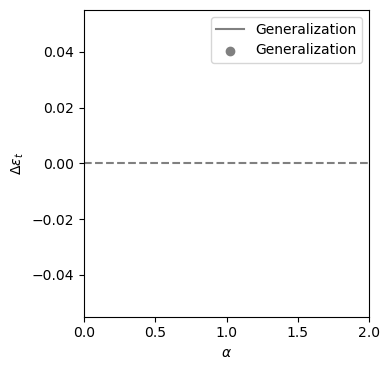

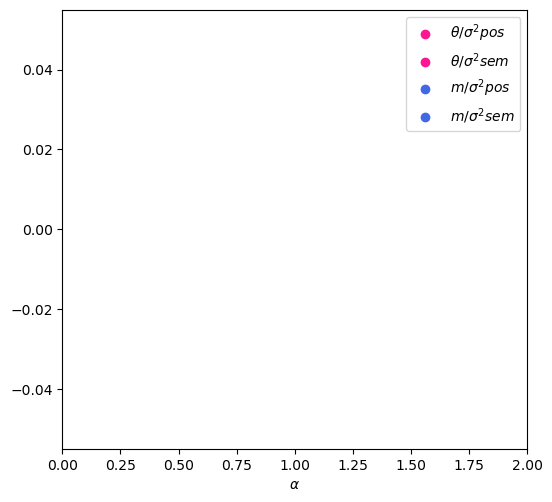

In [5]:
def plot_fig_2A(results):

    alphas = [r['alpha'] for r in results]
    deltas_gen = np.array([r['delta_gen'] for r in results])
    deltas_train = [r['delta_train'] for r in results]
    print(deltas_train)

    #fig = plt.figure(figsize=(4, 3.8))
    fig = plt.figure(figsize=(4, 3.8))
    plt.plot(alphas,deltas_gen, c='grey', label='Generalization')
    plt.scatter(alphas,deltas_gen, c='grey', label='Generalization')
   # plt.plot(alphas, deltas_train, c='black', linestyle='--', label='Training')
    plt.axhline(0, linestyle='--', color='grey')
    plt.xlabel(r'$\alpha$')
    plt.ylabel(r'$\Delta \epsilon_t$')
    plt.xlim(0.0, 2.0)
    #plt.ylim(-1e-1,1e-1)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_fig_2B(results):
    """
    Plots summary statistics(theta,m) vs alpha.
    """
    alphas = [r['alpha'] for r in results]
    m_pos = [r['m_pos'] for r in results]
    m_sem = [r['m_sem'] for r in results]
    theta_pos = [r['theta_pos'] for r in results]
    theta_sem = [r['theta_sem'] for r in results]
    theta_pos,theta_sem = np.array(theta_pos),np.array(theta_sem)
    m_pos,m_sem = np.array(m_pos),np.array(m_sem)
    fig=plt.figure(figsize=(4*1.5,3.8*1.5))

    sigma=0.5 # variance 0.25
    
    plt.plot(alphas,theta_sem/sigma**2, color=c_semantic)
    plt.plot(alphas,theta_pos/sigma**2, color=c_semantic)

    plt.scatter(alphas,theta_pos/sigma**2,label=r'$\theta/\sigma^2 pos$', color=c_semantic)
    plt.scatter(alphas,theta_sem/sigma**2,label=r'$\theta/\sigma^2 sem$', color=c_semantic)

    plt.plot(alphas,m_sem/sigma**2,  color=c_positional)
    plt.plot(alphas,m_pos/sigma**2,color=c_positional)
    plt.scatter(alphas,m_pos/sigma**2,label=r'$m/\sigma^2 pos$', color=c_positional)
    plt.scatter(alphas,m_sem/sigma**2,label=r'$m/\sigma^2 sem$', color=c_positional)
    
    plt.xlabel(r'$\alpha$')
    plt.xlabel(r'$\alpha$')
    plt.legend()
    plt.xlim(0.0,2.0)

plot_fig_2A(results)
plot_fig_2B(results)

In [6]:

class LinearModel(torch.nn.Module):  # linear attention
    def __init__(self, L):
        super(LinearModel, self).__init__()
        self.B = torch.nn.Parameter(torch.randn(L, L))

    def forward(self, x):
        yhat = self.B@x
        return yhat

# use GD
def train_linear(X_train,T_train, X_test, y_test,lmbda):

    model = LinearModel(L)

    optimizer = torch.optim.Adam(
        [{'params': [model.B], "weight_decay":lmbda}], lr=0.15)

    train_dataset = TensorDataset(X_train, T_train)
    train_loader = DataLoader(train_dataset, batch_size=D, shuffle=True)

    n_iter = 200
    for t in range(n_iter):
        for x, y in train_loader:
            y_pred = model(x)
            loss = loss_SSE(y_pred, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    gen_loss = loss_SSE(model(X_test),y_test).item()/y_test.shape[0]
    train_loss = loss.item()+lmbda/2*float(torch.sum(model.B.cpu().flatten()**2))

    return gen_loss,train_loss

def run_fig_2C(X,T,alphas):
    D = X.shape[2]
    L = X.shape[1]
    results = []

    # Fixed test set
    N_test = int(0.2 * D)
    X_test = X[-N_test:]
    T_test = T[-N_test:]

    for alpha in alphas:
        print(alpha)
        N_train = int(alpha * D)
        X_train = X[:N_train]
        T_train = T[:N_train]

        elin, elin_train = train_linear(X_train,T_train, X_test, T_test,lmbda=1e-4)          

        results.append({
            'alpha': alpha,
            'linear_gen_error': elin,
            'linear_train_error':elin_train
        })

    return (results)

def plot_fig2C(results_1,results_2):
    '''
    Plots for the dense linear baseline
    '''
    fig=plt.figure(figsize=(4,3.8))

    c_neutral = c_att  # 'black'

    alphas = np.array([result['alpha'] for result in results_2])
    lin_err = [result['linear_gen_error'] for result in results_2]
    sem_gen_err = np.array([r['semantic_loss_gen'] for r in results_1])
    pos_gen_err = np.array([r['positional_loss_gen'] for r in results_1])
    mask = alphas < 41.25

    plt.plot(alphas,lin_err)
    plt.axhline(np.mean(lin_err), color=c_lin, label=r'$\epsilon_g^{\mathrm{lin}}$')#,ls="--")
    #plt.scatter(alphas[mask],pos_gen_err[mask],color=c_neutral)
    #plt.plot(alphas[mask],pos_gen_err[mask],color=c_neutral)
    mask = ~mask
    plt.scatter(alphas[~mask],sem_gen_err[~mask],color=c_neutral)
    plt.plot(alphas[~mask],sem_gen_err[~mask],color=c_neutral)
    plt.scatter(alphas[~mask],pos_gen_err[~mask],color=c_neutral)
    plt.plot(alphas[~mask],pos_gen_err[~mask],color=c_neutral)
    
    plt.axvline(1.45,ymin=0, ymax=1, color="r", ls="--")

    plt.ylabel(r'$\epsilon_g$')
    plt.xlabel(r'$\alpha$')
    plt.legend()
    plt.xlim(0.0,2.0)
    plt.show()

    '''
    lin_error = results[]
    plt.plot(df_positional[df_positional["alpha"]<1.25].alpha,df_positional[df_positional["alpha"]<1.25].mse/2, color=c_neutral,label=r'$\epsilon_g^{\mathrm{minloss}}$')
    plt.plot(df_semantic[df_semantic["alpha"]>1.24].alpha,df_semantic[df_semantic["alpha"]>1.24].mse/2, color=c_neutral)

    plt.axvline(df_spinodal.loc[0.3].alpha_cross,ymin=0, ymax=1, color="g", ls="--")
    plt.axvline(1.45,ymin=0, ymax=1, color="r", ls="--")

    plt.xticks(ticks=[0.,.5,1.,2.] + [df_spinodal.loc[0.3].alpha_cross,1.45],labels=[str(i) for i in [0.,.5,1.,2.]]+[r"$\alpha_c$",r"$\alpha_l$"])


    plt.ylabel(r'$\epsilon_g$')
    plt.xlabel(r'$\alpha$')
    plt.legend()
    plt.xlim(0.0,2.0)
    plt.savefig(figure_dir / 'attention_gen_error_global_only.pdf', bbox_inches='tight')
    plt.show()
    '''

alphas = np.linspace(0.2,2,10)
results2 = run_fig_2C(X,T,alphas)
plot_fig2C(results,results2)


<>:93: SyntaxWarning: invalid escape sequence '\e'
<>:93: SyntaxWarning: invalid escape sequence '\e'
/var/folders/t2/b95676ns3dsgtbbt3q5ckmk40000gn/T/ipykernel_84349/1011834393.py:93: SyntaxWarning: invalid escape sequence '\e'
  '''


0.2
0.4
0.6000000000000001
0.8


/var/folders/t2/b95676ns3dsgtbbt3q5ckmk40000gn/T/ipykernel_84349/1011834393.py:93: SyntaxWarning: invalid escape sequence '\e'
  '''


KeyboardInterrupt: 

In [ ]:
'''
FIG 3:
FIG 3A -> ) Scaling d and n jointly for α = 1.5 concentrates for θ and m,
in different locations for the positional and semantic local minima each. We show 30 runs for each
d ∈ [10, 15, 23, 36, 56, 87, 135, 209, 323, 500]
FIG 3B -> alpha vs omega color plot of delta E training
FIG 3C ->  color map : difference in test MSE at convergence when training the attention model (13) using the Pytorch
implementation of full-batch gradient descent initialized at Q⋆, and the dense linear baseline (15).
The red dashed lines indicate the theoretical prediction –following from Result 4.2 and Result 15–
for the threshold sample complexity αl(ω) above which the dot-product attention (2) outperforms the
baseline
'''
alpha_cross = np.sort([0.5480511155124588,0.7071599112677189,0.9277860822926854,1.2410177405149914,1.06,1.4541109691229464,1.93929723421423,1.7505718608649372,0.8180015676221762])
omegas = np.sort([0.,.1,.2,.3,.25,.35,.425,.4,.15])
# 9x9 grid 
def fig3BC(alphas,omegas,D=1000,seed=42):
    results = []
    N = int(2.2*D)
    torch.manual_seed(seed)
    for omega in omegas:
        print("omega = ",omega)
        print(D)
        X, T, W_Q_teacher = generate_teacher_dataset(
            N=N, D=D, L=L, DK=DK, omega=omega, seed=seed
        )
        result = run_fig_2A(X,T,lam=1e-2,WQ_teacher=W_Q_teacher,alphas = alphas,epochs=10)
        result_lin = run_fig_2C(X,T,alphas)
        for res, lin_res in zip(result, result_lin):
            res['omega'] = omega
            res['lin_gen_error'] = lin_res['linear_gen_error']
            res['lin_train_error'] = lin_res['linear_train_error']
        results.append(result)
    return results # list of list of dictionaries
 
def convert_to_df(results):
    flat_results = [item for sublist in results for item in sublist]
    df = pd.DataFrame(flat_results)
    return df

def plot_Fig3B(df):
    alphas = np.array(sorted(df['alpha'].unique()))
    omegas = np.array(sorted(df['omega'].unique()))

    len_alpha = np.shape(alphas)[0]
    len_omega = np.shape(omegas)[0]
    delta_generalisation_error = np.array(df['delta_gen']).reshape(len_alpha,len_omega) # idk if this is correct

    vmax=0.0015
    plt.figure(figsize=(4,3.5))
    plt.imshow(delta_generalisation_error/10 ,#/ 1000, 
               aspect='auto',  
               cmap=cmap_uninf, 
               vmin=-vmax, vmax=vmax, 
               extent=[alphas[0], alphas[-1], omegas[0], omegas[-1]])
    
    plt.colorbar(label=r'$\Delta \epsilon_t$')
    plt.xlabel(r'$\alpha$')
    plt.ylabel(r'$\omega$')

    plt.ylim(0.01,0.5)
    plt.xlim(0,2.0)
    plt.show()

def plot_Fig3C(df):
    alphas = np.array(sorted(df['alpha'].unique()))
    omegas = np.array(sorted(df['omega'].unique()))
    print(alphas)
    print(omegas)

    len_alpha = np.shape(alphas)[0]
    len_omega = np.shape(omegas)[0]
    sem_error_gen = np.array(df['semantic_loss_gen'])
    lin_loss_gen = np.array(df['lin_gen_error'])
    
    delta_err = (lin_loss_gen-sem_error_gen).reshape(len_alpha,len_omega)

    fig=plt.figure(figsize=(4,3.5))
    vmax = 0.002
    #plt.pcolor(alphas,omegas,delta_err/1000,vmin=-vmax,vmax=vmax,cmap=cmap_uninf)
    plt.imshow(delta_err ,#/ 1000, 
               aspect='auto',  
               cmap=cmap_attlin, 
               vmin=-vmax, vmax=vmax, 
               extent=[alphas[0], alphas[-1], omegas[0], omegas[-1]])
    
    plt.colorbar(label=r'$\epsilon^{\mathrm{lin}}_g-\epsilon_g$')
    plt.xlabel(r'$\alpha$')
    plt.ylabel(r'$\omega$') 
    plt.ylim(0.01,0.5)
    plt.xlim(0,2.0)
    plt.show()


# use omega_list_short 
# make sure fig 2 plots are fine before going to this
results = fig3BC(alpha_cross ,omegas,D=1000)
df = convert_to_df(results)
plot_Fig3C(df)
plot_Fig3B(df)



In [ ]:
'''Scaling d and n jointly for α = 1.5 concentrates for θ and
m, in different locations for the positional and semantic local minima each. We show 30 runs for each
d ∈ [10, 15, 23, 36, 56, 87, 135, 209, 323, 500]. '''

def fig3A(d_list,alpha=1.5,omega=0.3):
    results = []
    for d in d_list:
        n = 2.2*d
        X, T, W_Q_teacher = generate_teacher_dataset(
            N=n, D=d, L=L, DK=DK, omega=omega, seed=seed
        )
        print(alpha)
        result = run_fig_2A(X,T,lam=1e-2,WQ_teacher=W_Q_teacher,alphas = alpha,epochs=50)
        results.append(result)
    return results

def plot_fig3A(df,D_list):
    sigma=0.5
    m_pos = np.array(df['m_pos'])
    m_sem = np.array(df['m_pos'])
    theta_pos = np.array(df['theta_pos'])
    theta_sem = np.array(df['theta_sem'])
    print(m_pos)
    print(m_sem)
    plt.scatter(m_sem/sigma**2,theta_sem/sigma**2,cmap=cmap_att, norm=colors.LogNorm())
    plt.scatter(m_sem/sigma**2, theta_sem/sigma**2, marker='+',c=D_list, cmap=cmap_att, norm=colors.LogNorm())
    plt.colorbar(label=r'$d$')
    plt.scatter(m_pos/sigma**2,theta_pos/sigma**2,cmap=cmap_pos, norm=colors.LogNorm())
    plt.scatter(m_pos/sigma**2,theta_sem/sigma**2,marker='+',c=D_list, cmap=cmap_pos, norm=colors.LogNorm())
    plt.colorbar()
    plt.scatter([],[],marker='+',c=c_semantic,label='semantic')
    plt.scatter([],[],marker='+',c=c_positional,label='positional')

    plt.legend()
    plt.xlabel(r'$m/\sigma^2$')
    plt.ylabel(r'$\theta/\sigma^2$')

alpha = [1.5]
omega = 0.3
d = np.array([10, 15, 23, 36, 56, 87, 135, 209, 323, 500])
#results = fig3A(d,alpha,omega)
df = convert_to_df(results)
plot_fig3A(df,d)